# Introduccion

Rusty Bargain, empresa dedicada a la venta de carros usados, se encuentra desarrollando una app para atraer nuevos clientes, lo que hace atractiva la app es que pueda averiguar rápidamente el valor de mercado del coche del cliente. 

# Recursos

La compañia proporciona la siguiente información:

     - especificaciones técnicas
     - versiones de equipamiento
     - precios

# Objetivo

Crear un modelo que determine el valor de mercado de los vehiculos de los clientes. El modelo debe complir con los siguientes requerimientos:

    - la calidad de la predicción
    - la velocidad de la predicción
    - el tiempo requerido para el entrenamiento

## Preparación de datos

Importación de librerias

In [1]:
import pandas as pd 
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as ltb 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline

from catboost import CatBoostRegressor, Pool
from time import time


In [2]:
df  = pd.read_csv("/datasets/car_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
display(df) 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


In [5]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
print(f'El número total de filas duplicadas en este archivo es de {df.duplicated().sum()} filas.')

El número total de filas duplicadas en este archivo es de 262 filas.


In [7]:
duplicates = df[df.duplicated()]
print(duplicates)

             DateCrawled  Price  VehicleType  RegistrationYear Gearbox  Power  \
14266   21/03/2016 19:06   5999        small              2009  manual     80   
27568   23/03/2016 10:38  12200          bus              2011  manual    125   
31599   03/04/2016 20:41   4950        wagon              2003    auto    170   
33138   07/03/2016 20:45  10900  convertible              2005    auto    163   
43656   13/03/2016 20:48   4200        sedan              2003  manual    105   
...                  ...    ...          ...               ...     ...    ...   
349709  03/04/2016 20:52    700        small              1999  manual     60   
351555  26/03/2016 16:54   3150          bus              2003  manual     86   
352384  15/03/2016 21:54   5900        wagon              2006  manual    129   
353057  05/03/2016 14:16   9500        small              2013  manual    105   
353727  20/03/2016 17:56      1          NaN              2000     NaN      0   

           Model  Mileage  

In [8]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Descripción de los datos

El dataset proporcionado  cuenta con un total de registros de 354,369 y 16 columnas, de las cuales tenemos la siguiente información:

| Nombre de columna | Característica | Tipo de dato | Datos Nulos |
|-------------------|----------------|--------------|-------------|
| DateCrawled | Fecha en la que se descargó el perfil de la base de datos | object | 0 |
| Price | Precio | int64 | 0 |
| VehicleType | Tipo de carrocería del vehículo | object | 37,490 |
| RegistrationYear | Año de matriculación del vehículo | int64 | 0 |
| Gearbox | Tipo de caja de cambios | object | 19,833 |
| Power | Potencia (CV) | int64 | 0 |
| Model | Modelo del vehículo | object | 19,705 |
| Mileage | Kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos) | int64 | 0 |
| RegistrationMonth | Mes de matriculación del vehículo | int64 | 0 |
| FuelType | Tipo de combustible | object | 32,895 |
| Brand | Marca del vehículo | object | 0 |
| NotRepaired | Vehículo con o sin reparación | object | 71,154 |
| DateCreated | Fecha de creación del perfil | object | 0 |
| NumberOfPictures | Número de fotos del vehículo | int64 | 0 |
| PostalCode | Código postal del propietario del perfil (usuario) | int64 | 0 |
| LastSeen | Fecha de la última vez que el usuario estuvo activo | object | 0 |

Las columnas con fechas serán cambiados su tipo de datos: 

    - Solo se dejará año
        DateCrawled
        DateCreated
        LastSeen


Se tiene este total de valores asentes:

    VehicleType          37490 object 10.58%
    Gearbox              19833 object 5.6%
    Model                19705 object 5.6%
    FuelType             32895 object 9.28%
    NotRepaired          71154 object 20.08%

Los primeros 4 tipos de datos se pueden intentar llenar con kNN vecinos.
NotRepaired se rellanará con datos NaN.

Se observa que las columnas 'Price', 'Power' y tienen celdas con valores en 0, lo que podría ser anormal.

Los datos en la columna 'RegistrationYear' tiene un rango de años estraño que va del 1000 al 9999.
Se desconoce la razón por la cual la columna 'NumberOfPictures' presenta sus datos en 0.

El número total de filas duplicadas en este archivo es de 262 filas, mismas que se procederan a eliminarse, debido a que son muy pocos registro, que hay duplicados en filas que incluyen fecha y hora exacta y que no se puede investigar la razón de su probable duplicidad.

In [9]:
df = df.drop_duplicates()

In [10]:
print(f'El número total de filas duplicadas en este archivo es de {df.duplicated().sum()} filas.')

El número total de filas duplicadas en este archivo es de 0 filas.


Cambio de nombre de las columnas a snake case!

In [11]:
def to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [12]:
df.columns = [to_snake_case(col) for col in df.columns]

In [13]:
display(df)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


Cambio de tipo de dato a las columnas con fecha

In [14]:
columns_date = ['date_crawled', 'date_created', 'last_seen']

In [15]:
for columns in columns_date:
    df[columns] = pd.to_datetime(df[columns], infer_datetime_format=True)

In [16]:
for columns in columns_date:
    df[columns] = pd.DatetimeIndex(df[columns]).year 

display(df)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016,0,70435,2016
1,2016,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016,0,66954,2016
2,2016,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016,0,90480,2016
3,2016,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,0,91074,2016
4,2016,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016,0,60437,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016,0,2694,2016
354365,2016,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016,0,39576,2016
354366,2016,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016,0,26135,2016
354367,2016,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016,0,87439,2016


Ya con los datos duplicados eliminados, y las fechas ya adaptadas se procede a revisar lo antes indicado.

Se revisa profundamente las columnas 'Price', 'Power'y  'RegistrationYear'

In [17]:
df.loc[:,['price', 'power', 'registration_year']].describe()

,price,power,registration_year
count,354107.000000,354107.000000,354107.000000
mean,4416.433287,110.089651,2004.235355
std,4514.338584,189.914972,90.261168
min,0.000000,0.000000,1000.000000
25%,1050.000000,69.000000,1999.000000
50%,2700.000000,105.000000,2003.000000
75%,6400.000000,143.000000,2008.000000
max,20000.000000,20000.000000,9999.000000


Se elimina la columna 'number_of_pictures' dado que todos sus valores estan en 0

In [18]:
df = df.drop('number_of_pictures',axis=1)

La composición de los datos ausentes es de la siguiente forma:

    NotRepaired          71154 object 20.08%
    VehicleType          37490 object 10.58%
    FuelType             32895 object 9.28%
    Gearbox              19833 object 5.6%
    Model                19705 object 5.6%

Se buscan las frecuencias relativas de estas columnas:

In [19]:
def category_distribution(df, column):
    
    print(f'Distribution for {column}')
    print(df[column].value_counts(normalize=True, dropna=False))
    print()


In [20]:
cat_cols = ['not_repaired', 'vehicle_type', 'fuel_type', 'gearbox', 'model']
for col in cat_cols:
    category_distribution(df, col)

Distribution for not_repaired
no     0.697323
NaN    0.200914
yes    0.101763
Name: not_repaired, dtype: float64

Distribution for vehicle_type
sedan          0.258111
small          0.225223
wagon          0.183885
NaN            0.105855
bus            0.081196
convertible    0.056988
coupe          0.045599
suv            0.033863
other          0.009280
Name: vehicle_type, dtype: float64

Distribution for fuel_type
petrol      0.610440
gasoline    0.278611
NaN         0.092879
lpg         0.014987
cng         0.001596
hybrid      0.000658
other       0.000576
electric    0.000254
Name: fuel_type, dtype: float64

Distribution for gearbox
manual    0.756929
auto      0.187071
NaN       0.056000
Name: gearbox, dtype: float64

Distribution for model
golf                  0.082503
other                 0.068911
3er                   0.055757
NaN                   0.055636
polo                  0.036873
                        ...   
serie_2               0.000023
rangerover            0

Para la columna 'not_repaired' no se tiene información suficiente para realizar imputación de datos, por lo que se opta por colocar en los datos ausentes la palabra 'unknown'.

In [21]:
df['not_repaired'].fillna('unknown', inplace=True)

En el caso de 'gearbox' se trabaja una moda condiconal, tomando como referencia la columna 'brand'. Se crea una función que tome como entrada un conjunto de columnas y devuelve el valor más frecuente en cada columna.

In [22]:
def replace_null(cols):
    return cols.astype(str).mode(dropna=False).iloc[0]

Se aplica a 'gearbox'

In [23]:
conditional_gearbox = df.groupby(['brand'])['gearbox'] \
         .transform(replace_null)

df['gearbox'] = df['gearbox'].fillna(conditional_gearbox)

In [24]:
category_distribution(df, 'gearbox')

Distribution for gearbox
manual    0.806287
auto      0.193713
Name: gearbox, dtype: float64



De esta manera se asigna un valor adecuado a los datos ausentes. 

Para 'vehicle_type', 'fuel_type', 'model' revisa más a fondo para rellenar los NaN con datos más especificos. Se revisan sus frecuencias relativas.

In [25]:
opt_cols = ['registration_year', 'power', 'brand']
for col in opt_cols:
    category_distribution(df, col)

Distribution for registration_year
2000    0.069120
1999    0.064113
2005    0.062394
2001    0.056782
2006    0.056124
          ...   
4100    0.000003
1200    0.000003
5300    0.000003
8888    0.000003
2290    0.000003
Name: registration_year, Length: 151, dtype: float64

Distribution for power
0        0.113576
75       0.067779
60       0.044842
150      0.041149
101      0.037520
           ...   
323      0.000003
3454     0.000003
1056     0.000003
13636    0.000003
1158     0.000003
Name: power, Length: 712, dtype: float64

Distribution for brand
volkswagen        0.217335
opel              0.112683
bmw               0.104152
mercedes_benz     0.090439
audi              0.083136
ford              0.071060
renault           0.050592
peugeot           0.031030
fiat              0.027206
seat              0.019488
mazda             0.015845
skoda             0.015504
smart             0.014801
citroen           0.014524
nissan            0.013939
toyota            0.012993
hyunda

In [26]:
df['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

En 'registration_year' se tienen datos incoherentes y se decide quitar estos datos

In [27]:
df = df.loc[~((df['registration_year'] <= 1800) | (df['registration_year'] >= 2066)), :]

print(df['registration_year'].sort_values().unique())

[1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933 1934
 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949
 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353936 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        353936 non-null  int64 
 1   price               353936 non-null  int64 
 2   vehicle_type        316623 non-null  object
 3   registration_year   353936 non-null  int64 
 4   gearbox             353936 non-null  object
 5   power               353936 non-null  int64 
 6   model               334310 non-null  object
 7   mileage             353936 non-null  int64 
 8   registration_month  353936 non-null  int64 
 9   fuel_type           321175 non-null  object
 10  brand               353936 non-null  object
 11  not_repaired        353936 non-null  object
 12  date_created        353936 non-null  int64 
 13  postal_code         353936 non-null  int64 
 14  last_seen           353936 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 43.2+ MB


La eliminación de esta información no fue significativa para el dataset completo..

Con los datos finales se revisa el tipo de vehículos que se tienen y la cantidad que hay por tipo. El objetivo es llenar los datos ausentes con el tipo de vehículo más significativo por modelo.

Para ello, se buscará los modelos con mayor cantidad de datos ausentes y se les imputará la moda.

In [29]:
nan_counts = df[df['vehicle_type'].isna()]['model'].value_counts().head(30)
relative_frequency = nan_counts / nan_counts.sum()

relative_frequency

golf           0.183948
other          0.084195
polo           0.073076
corsa          0.071840
3er            0.059806
astra          0.054269
a3             0.035508
twingo         0.032534
passat         0.030933
fiesta         0.028645
a_klasse       0.025945
focus          0.024252
punto          0.021964
a4             0.021415
vectra         0.020317
c_klasse       0.018715
transporter    0.018349
clio           0.017937
touran         0.017434
5er            0.016153
ka             0.015970
zafira         0.015832
e_klasse       0.015649
3_reihe        0.014322
ibiza          0.014094
fortwo         0.014002
megane         0.013956
lupo           0.013133
a6             0.012950
2_reihe        0.012858
Name: model, dtype: float64

Se decide trabajar con los primeros 18 registros, que representan el 80% de los datos. 

In [30]:
model_mode = df.groupby('model')['vehicle_type'].agg(pd.Series.mode)
model_mode

model
100              sedan
145              small
147              sedan
156              wagon
159              wagon
              ...     
yaris            small
yeti               suv
ypsilon          small
z_reihe    convertible
zafira             bus
Name: vehicle_type, Length: 250, dtype: object

In [31]:
models = ['golf', 'other', 'polo', 'corsa', '3er', 'astra', 'a3', 'twingo', 
          'passat', 'fiesta', 'a_klasse', 'focus', 'punto', 'a4', 'vectra', 
          'c_klasse', 'transporter', 'clio']

In [32]:
for v_type in models:
    print (v_type,':',model_mode[v_type])

golf : sedan
other : sedan
polo : small
corsa : small
3er : sedan
astra : sedan
a3 : sedan
twingo : small
passat : wagon
fiesta : small
a_klasse : sedan
focus : wagon
punto : small
a4 : wagon
vectra : sedan
c_klasse : sedan
transporter : bus
clio : small


In [33]:
df['vehicle_type'] = np.where(
    (df['vehicle_type'].isna()==True) & (df['model'].isin(['golf', 'other ', '3er', 'astra', 'a3', 'a_klasse', 'vectra', 'c_klasse'])), 'sedan',
    np.where((df['vehicle_type'].isna()==True) & (df['model'].isin(['polo', 'corsa', 'twingo', 'fiesta', 'punto', 'clio'])), 'small',
    np.where((df['vehicle_type'].isna()==True) & (df['model'].isin(['passat', 'focus', 'a4'])), 'wagon',
    np.where((df['vehicle_type'].isna()==True) & (df['model'] == 'transporter'), 'bus', df['vehicle_type']))))

df.dropna(subset=['vehicle_type'], inplace=True)

Se sigue sigue el mismo patrón anterior para los datos ausentes de 'fuel_type'.

In [34]:
fuel_mode = df.groupby('vehicle_type')['fuel_type'].agg(pd.Series.mode)
print(fuel_mode)

vehicle_type
bus            gasoline
convertible      petrol
coupe            petrol
other          gasoline
sedan            petrol
small            petrol
suv            gasoline
wagon          gasoline
Name: fuel_type, dtype: object


In [35]:
for vehicle_type, fuel in fuel_mode.items():
    df.loc[df['vehicle_type'] == vehicle_type, 'fuel_type'] = df.loc[df['vehicle_type'] == vehicle_type, 'fuel_type'].fillna(fuel)


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332783 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        332783 non-null  int64 
 1   price               332783 non-null  int64 
 2   vehicle_type        332783 non-null  object
 3   registration_year   332783 non-null  int64 
 4   gearbox             332783 non-null  object
 5   power               332783 non-null  int64 
 6   model               319909 non-null  object
 7   mileage             332783 non-null  int64 
 8   registration_month  332783 non-null  int64 
 9   fuel_type           332783 non-null  object
 10  brand               332783 non-null  object
 11  not_repaired        332783 non-null  object
 12  date_created        332783 non-null  int64 
 13  postal_code         332783 non-null  int64 
 14  last_seen           332783 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 40.6+ MB


Por ultimo, se utiliza la función previamente creada para el calculo de la moda de la columna 'model' para cada combinación única de 'brand' y 'registration_year' y que reemplace los valores faltantes en 'model' con estas modas calculadas.

In [37]:
conditional_model = df.groupby(['brand', 'registration_year'])['model'] \
         .transform(replace_null)

df['model'] = df['model'].fillna(conditional_model)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332783 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        332783 non-null  int64 
 1   price               332783 non-null  int64 
 2   vehicle_type        332783 non-null  object
 3   registration_year   332783 non-null  int64 
 4   gearbox             332783 non-null  object
 5   power               332783 non-null  int64 
 6   model               332783 non-null  object
 7   mileage             332783 non-null  int64 
 8   registration_month  332783 non-null  int64 
 9   fuel_type           332783 non-null  object
 10  brand               332783 non-null  object
 11  not_repaired        332783 non-null  object
 12  date_created        332783 non-null  int64 
 13  postal_code         332783 non-null  int64 
 14  last_seen           332783 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 40.6+ MB


In [39]:
nan_count_model = df['model'].value_counts()['nan']
print("Cantidad de 'nan' en la columna 'model':", nan_count_model)

Cantidad de 'nan' en la columna 'model': 2378


Algunos datos que quedaban ausentes, se quedarán como datos desconocidos con el nombr de 'nan'

Para terminar la preparación de datos, se revisa el tema de los datos mínimos de la columna 'price'y 'power'.

In [40]:
columns_interest = ['price', 'power']

for col in columns_interest:
    print('\n',col)
    print(df[col].sort_values().unique())


 price
[    0     1     2 ... 19998 19999 20000]

 power
[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   111   112   113   114   115   116   117   118   119
   120   121   122   123   124   125   126   127   128   129   130   131
   132   133   134   135   136   137   138   139   140   141   142   143
   144   145   146   147   148   149   150   151   152   153   154

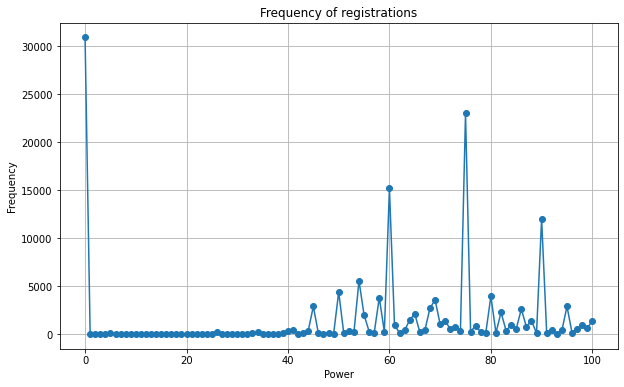

In [41]:
df_filtered_power = df[(df['power'] >= 0) & (df['power'] <= 100)]

value_frequency_2 = df_filtered_power['power'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(value_frequency_2.index, value_frequency_2.values, marker='o', linestyle='-')
plt.xlabel('Power')
plt.ylabel('Frequency')
plt.title('Frequency of registrations')
plt.grid(True)
plt.show()

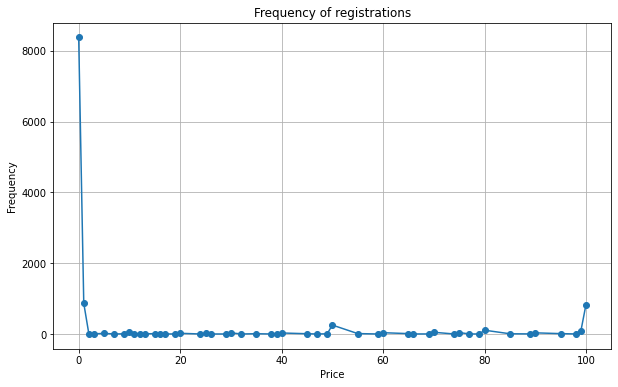

In [42]:
df_filtered_price = df[(df['price'] >= 0) & (df['price'] <= 100)]

value_frequency_3 = df_filtered_price['price'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(value_frequency_3.index, value_frequency_3.values, marker='o', linestyle='-')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Frequency of registrations')
plt.grid(True)
plt.show()

Se decide observar el comportamiento de los datos para considerar los datos que se conservarán.

        Para Power a partir de 40
        Para Price a partir de 50

In [43]:
df = df.loc[(df['power'] >= 40) & (df['price'] >= 50)]

In [44]:
df = df.reset_index(drop=True)

In [45]:
display(df)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
0,2016,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,2016,66954,2016
1,2016,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016,90480,2016
2,2016,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,91074,2016
3,2016,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016,60437,2016
4,2016,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016,33775,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293814,2016,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no,2016,75223,2016
293815,2016,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016,96465,2016
293816,2016,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016,26135,2016
293817,2016,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016,87439,2016


El total de observaciones originales era de 354369 y después de la preparación ya decuación de los datos, se trabajará con un total de 293819 observaciones. La limpieza supuso una pérdida del 17.09% de los datos.


Por último, para determinar con qué columnas trabajar, se revisa la correlación de las variables

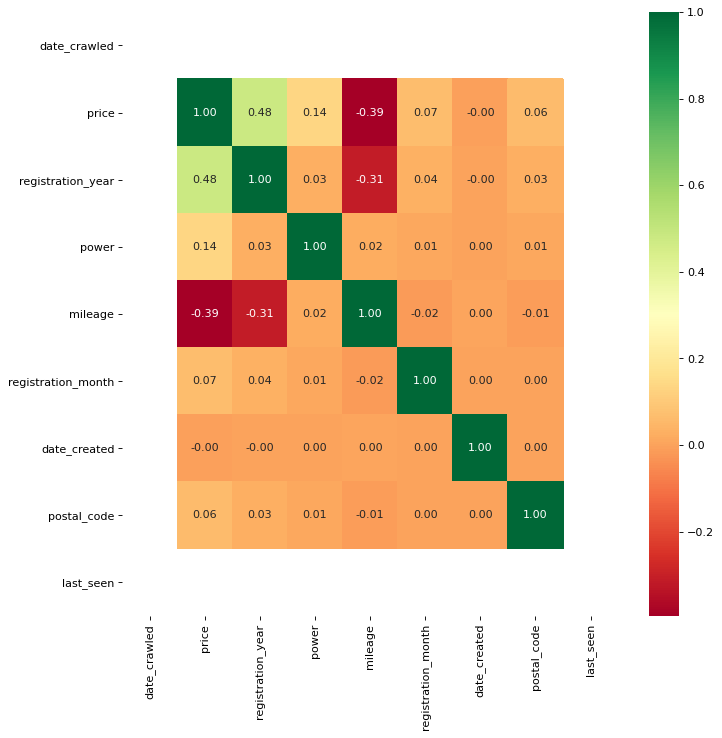

In [46]:
plt.figure(figsize=(10, 10), dpi=80)
sns.heatmap(df.corr(), annot=True, cmap="RdYlGn", fmt=".2f")
plt.show()

La matriz de correlación muestra que no hay relación entre el precio y las columnas: 'date_crawled', 'registration_month', 'date_created', 'postal_code' y 'last_seen'.

Por lo cual se dejarán fuera de los modelos. Por lo que la información con la que se trabajará será el siguiente:

Columna objetivo

    price - precio al que se vende el vehículo

Columnas características

    vehicle_type - tipo de carrocería del vehículo
    registration_year - año de matriculación del vehículo
    gearbox - tipo de caja de cambios
    power - potencia (CV)
    model - modelo
    mileage - kilometraje (Km)
    fuel_type - tipo de combustible
    brand - marca del vehículo
    not_repaired - vehículo con o sin reparación

## Entrenamiento del modelo 

Se entrena diferentes modelos con varios hiperparámetros con el objetivo de comparar la métrica raíz del error cuadrático medio (RECM).

Se ejecutarán las siguientes modelos:

    - Modelo de regresión lineal (como prueba de cordura)
    - Modelo árbol de decision
    - Modelo bosque aleatorio
    - LightGBM

### Separación y división de datos

Eliminamos las columnas que ya no se necesitan

In [47]:
df = df.drop(['date_crawled', 'registration_month', 'date_created', 'postal_code', 'last_seen'],axis=1)

Se aplica  la codificación one-hot a las variables categóricas

In [48]:
df = pd.get_dummies(df, drop_first=True)

Se separan el conjunto de price 75% entrenamiento, 25% de validación

In [49]:
target = df['price']
features = df.drop('price', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Se realiza el escalado de los datos númericos

In [50]:
numeric_features_train = features_train.select_dtypes(include=['number'])
numeric_features_valid = features_valid.select_dtypes(include=['number'])
scaler = StandardScaler()
numeric_features_train_scaled = scaler.fit_transform(numeric_features_train)
numeric_features_valid_scaled = scaler.transform(numeric_features_valid)


categorical_features_train = features_train.select_dtypes(exclude=['number'])
categorical_features_valid = features_valid.select_dtypes(exclude=['number'])


features_train_complete = np.hstack((numeric_features_train_scaled, categorical_features_train))
features_valid_complete = np.hstack((numeric_features_valid_scaled, categorical_features_valid))

Se crea la función que nos ayudará al calculo de los tiempos de entrenamiento y validación

In [51]:
def train_and_pred_time(model, features_train, target_train, features_valid):
    start_time1 = time()
    train = model.fit(features_train, target_train)
    end_time1 = time()
    train_time = end_time1 - start_time1
    
    start_time2 = time()
    predictions = model.predict(features_valid)
    end_time2 = time()
    pred_time = end_time2 - start_time2
    
    return train_time, pred_time, predictions

### Modelos

*Regresión Lineal*

In [52]:
model_lr = LinearRegression() 
lr_train_time, lr_pred_time, lr_pred = train_and_pred_time(model_lr, features_train_complete, target_train,
                                                           features_valid_complete)

In [53]:
lr_train_rmse = round(mean_squared_error(target_train, model_lr.predict(features_train_complete), squared=False),2)
lr_valid_rmse = round(mean_squared_error(target_valid,lr_pred, squared=False),2)

print('Valor RMSE para el entrenamiento:', lr_train_rmse) 
print('Valor RMSE para la validation:', lr_valid_rmse)
print('Tiempo de entrenamiento:', lr_train_time)
print('Tiempo de predicción:', lr_pred_time)

Valor RMSE para el entrenamiento: 2787.56
Valor RMSE para la validation: 2822.19
Tiempo de entrenamiento: 17.18407702445984
Tiempo de predicción: 0.08789730072021484


*Regresión lineal con uso de Descenso de Gradientes Estocástico*

In [54]:
model_sgd = SGDRegressor(max_iter=1000, tol=1e-3, random_state=12345)
sgd_train_time, sgd_pred_time, sgd_pred = train_and_pred_time(model_sgd, features_train_complete, target_train,
                                                           features_valid_complete)

In [55]:
sgd_train_rmse = round(mean_squared_error(target_train, model_sgd.predict(features_train_complete), squared=False),2)
sgd_valid_rmse = round(mean_squared_error(target_valid,sgd_pred, squared=False),2)

print('Valor RMSE para el entrenamiento:',sgd_train_rmse) 
print('Valor RMSE para la validation:',sgd_valid_rmse) 
print('Tiempo de entrenamiento:', sgd_train_time)
print('Tiempo de predicción:', sgd_pred_time)

Valor RMSE para el entrenamiento: 85674894844.94
Valor RMSE para la validation: 69472856038.69
Tiempo de entrenamiento: 24.453850746154785
Tiempo de predicción: 0.036748647689819336


*Árbol de desición*

Se buscan los mejores hiperparámetros con una grilla, y se implementa el modelo con los mejores hiperparámetros encontrados

In [56]:
param_grid = {'max_depth': [1,2,4,6,8,10,15,20]}
tree_reg = DecisionTreeRegressor(random_state=12345)
grid_search = GridSearchCV(estimator=tree_reg, param_grid=param_grid, cv=5, verbose=True)
%time grid_search.fit(features_train_complete, target_train)
best_model_tree_reg = grid_search.best_estimator_

dtr_train_time, dtr_pred_time, dtr_pred = train_and_pred_time(best_model_tree_reg, features_train_complete, 
                                                                                   target_train, features_valid_complete)

dtr_train_rmse = round(mean_squared_error(target_train, best_model_tree_reg.predict(features_train_complete), 
                                                 squared=False), 2)
dtr_valid_rmse = round(mean_squared_error(target_valid, dtr_pred, squared=False), 2) 

print('\nValor RMSE para el entrenamiento:', dtr_train_rmse) 
print('Valor RMSE para la validación:', dtr_valid_rmse) 
print('Tiempo de entrenamiento:', dtr_train_time)
print('Tiempo de predicción:', dtr_pred_time)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: user 2min 18s, sys: 4.27 s, total: 2min 22s
Wall time: 2min 22s

Valor RMSE para el entrenamiento: 1171.93
Valor RMSE para la validación: 1794.81
Tiempo de entrenamiento: 6.150753974914551
Tiempo de predicción: 0.06496429443359375


*Random Forest*

Igualmente aplicamos grilla en la busqueda de los mejores hiperparámetros y se implementan en el modelo

In [57]:
model_rfr =RandomForestRegressor(random_state=12345)
param_grid = {'n_estimators': [1,2,3,4,6,8,10],'max_features': [ 'sqrt', 'log2'],'max_depth' : [2,3,4,5,6,8,10]}
grid_search_rfr = GridSearchCV(estimator = model_rfr, param_grid = param_grid, cv= 5)
grid_search_rfr.fit(features_train_complete, target_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 8, 10],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [1, 2, 3, 4, 6, 8, 10]})

In [59]:
best_model_rfr = grid_search_rfr.best_estimator_

rfr_train_time, rfr_pred_time, rfr_pred = train_and_pred_time(best_model_rfr, features_train_complete, target_train, features_valid_complete)

rfr_train_rmse = round(mean_squared_error(target_train, best_model_rfr.predict(features_train_complete), squared=False), 2)
rfr_valid_rmse = round(mean_squared_error(target_valid, rfr_pred, squared=False), 2)

print('Valor RMSE para el entrenamiento:', rfr_train_rmse) 
print('Valor RMSE para la validación:', rfr_valid_rmse) 
print('Tiempo de entrenamiento:', rfr_train_time)
print('Tiempo de predicción:', rfr_pred_time)


Valor RMSE para el entrenamiento: 2766.22
Valor RMSE para la validación: 2800.35
Tiempo de entrenamiento: 0.881359338760376
Tiempo de predicción: 0.0666193962097168


*LightGBM*

In [60]:
model_ltb1= ltb.LGBMRegressor(boosting_type='gbdt',num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100)

ltb_train_time1, ltb_pred_time1, ltb_pred1 = train_and_pred_time(model_ltb1, features_train_complete, target_train,
                                                           features_valid_complete)

In [61]:
ltb1_train_rmse = round(mean_squared_error(target_train, model_ltb1.predict(features_train_complete), squared=False), 2)
ltb1_valid_rmse = round(mean_squared_error(target_valid, ltb_pred1, squared=False), 2)

print('Valor RMSE para el entrenamiento:',ltb1_train_rmse) 
print('Valor RMSE para la validation:',ltb1_valid_rmse) 
print('Tiempo de entrenamiento:', ltb_train_time1)
print('Tiempo de predicción:', ltb_pred_time1)

Valor RMSE para el entrenamiento: 1634.28
Valor RMSE para la validation: 1665.22
Tiempo de entrenamiento: 14.267228603363037
Tiempo de predicción: 1.0078754425048828


In [62]:
model_ltb2=ltb.LGBMRegressor(boosting_type='gbdt',num_leaves=20, max_depth=10, learning_rate=0.05, n_estimators=100)

ltb_train_time2, ltb_pred_time2, ltb_pred2 = train_and_pred_time(model_ltb2, features_train_complete, target_train,
                                                           features_valid_complete)

In [63]:
ltb2_train_rmse = round(mean_squared_error(target_train, model_ltb2.predict(features_train_complete), squared=False),2)
ltb2_valid_rmse = round(mean_squared_error(target_valid, ltb_pred2, squared=False),2)


print('Valor RMSE para el entrenamiento:',ltb2_train_rmse) 
print('Valor RMSE para la validation:',ltb2_valid_rmse) 
print('Tiempo de entrenamiento:', ltb_train_time2)
print('Tiempo de predicción:', ltb_pred_time2)

Valor RMSE para el entrenamiento: 1780.13
Valor RMSE para la validation: 1800.62
Tiempo de entrenamiento: 14.393465280532837
Tiempo de predicción: 0.816641092300415


## Análisis del modelo

In [64]:
model_names = ['Regresión Lineal', 'Descenso de Gradientes Estocástico', 'Árbol de desición', 'Bosque Aleatorio', 'LightGBM_1', 'LightGBM_2']

scores = [lr_valid_rmse, sgd_valid_rmse, dtr_valid_rmse, rfr_valid_rmse, ltb1_valid_rmse, ltb2_valid_rmse]
training_times = [lr_train_time, sgd_train_time, dtr_train_time, rfr_train_time, ltb_train_time1, ltb_train_time2]
prediction_times = [lr_pred_time, sgd_pred_time, dtr_pred_time, rfr_pred_time, ltb_pred_time1, ltb_pred_time2]


models_df = pd.DataFrame({
    'Model': model_names,
    'RMSE': scores,
    'Training Time': training_times,
    'Prediction Time': prediction_times
})

print(models_df)


                                Model          RMSE  Training Time  \
0                    Regresión Lineal  2.822190e+03      17.184077   
1  Descenso de Gradientes Estocástico  6.947286e+10      24.453851   
2                   Árbol de desición  1.794810e+03       6.150754   
3                    Bosque Aleatorio  2.800350e+03       0.881359   
4                          LightGBM_1  1.665220e+03      14.267229   
5                          LightGBM_2  1.800620e+03      14.393465   

   Prediction Time  
0         0.087897  
1         0.036749  
2         0.064964  
3         0.066619  
4         1.007875  
5         0.816641  


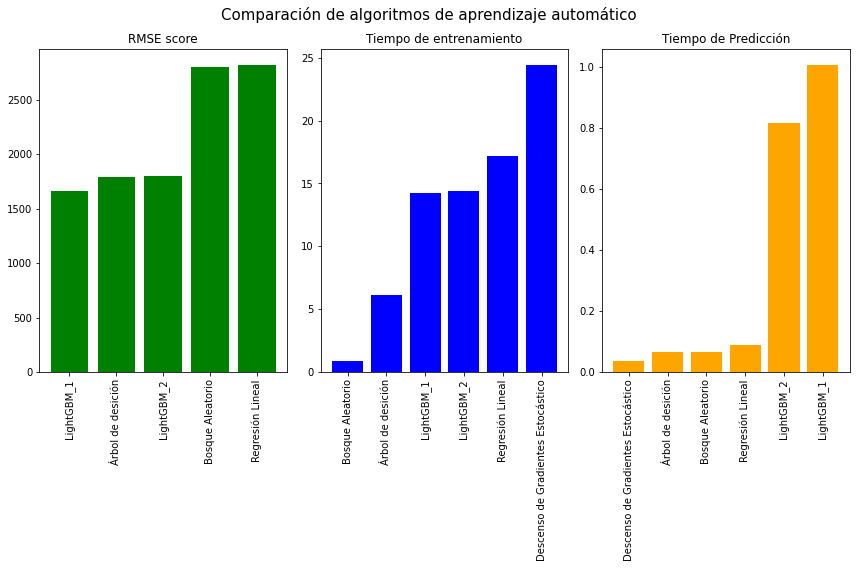

In [68]:
models_sorted_rmse = models_df.sort_values(by='RMSE')
models_sorted_training = models_df.sort_values(by='Training Time')
models_sorted_prediction = models_df.sort_values(by='Prediction Time')

filtered_df_dge = models_df[models_df['Model'] != 'Descenso de Gradientes Estocástico']
filtered_sorted_rmse_dge = filtered_df_dge.sort_values(by='RMSE')

fig, axs = plt.subplots(1, 3, figsize=(12, 8))
fig.suptitle('Comparación de algoritmos de aprendizaje automático', fontsize=15)


axs[0].bar(filtered_sorted_rmse_dge['Model'], filtered_sorted_rmse_dge['RMSE'], color='g')
axs[0].set_xticks(np.arange(len(filtered_sorted_rmse_dge['Model'])))
axs[0].set_xticklabels(filtered_sorted_rmse_dge['Model'], rotation=90)
axs[0].set_title('RMSE score')


axs[1].bar(models_sorted_training['Model'], models_sorted_training['Training Time'], color='b')
axs[1].set_xticks(np.arange(len(models_sorted_training['Model'])))
axs[1].set_xticklabels(models_sorted_training['Model'], rotation= 90)
axs[1].set_title('Tiempo de entrenamiento')


axs[2].bar(models_sorted_prediction['Model'], models_sorted_prediction['Prediction Time'], color='orange')
axs[2].set_xticks(np.arange(len(models_sorted_prediction['Model'])))
axs[2].set_xticklabels(models_sorted_prediction['Model'], rotation= 90)
axs[2].set_title('Tiempo de Predicción')

plt.tight_layout()
plt.show()

# Concluciones

Después de la importanción de datos, se procedió a revisar con qué tipo de datos contabamos y a la misma vez, saber que columnas tenian datos nulos. Se siguieron diferentes estrategias para trabajar los datos nulos, desde la eliminación de columnas que no tenian aportación a la inforación de los datos y a la imputación de los datos a travez de modas condiconales.

Una vez con los datos limpios se comienza a trabajar en la implementación de modelos, para ello, se uso la técnica de ONE HOT para datos categoricos y StandarScaler para datos númericos.

Se procede a trabajar con los modelos:

    - Regresión Lineal 
    - Descenso de Gradientes Estocástico
    - Árbol de desición
    - Bosque Aleatorio
    - LightGBM

donde se calculó el Error Cuadrático Medio (RMSE) y los tiempos de entrenamiento y predicción, donde se puede observar los siguiente:

Con base a la observación de resultados el modelo LightGBM_1 parece ser la mejor opción para determinar el valor de mercado de los vehículos de los clientes. Este modelo tiene un RMSE bajo, lo que indica que sus predicciones son precisas, su tiempo de predicción se puede considerar y su  tiempo de entrenamiento es aceptable, considerando la precisión y velocidad del modelo.

Observaciones del resto de modelos:

Regresión Lineal: Este modelo tiene el segundo mejor RMSE, pero su tiempo de predicción es más lento que el de LightGBM_1.
Descenso de Gradientes Estocástico: Este modelo tiene un RMSE muy alto, lo que lo hace inadecuado para esta tarea.
Árbol de Decisión: Este modelo tiene un RMSE similar al de LightGBM_1, pero su tiempo de predicción es más lento.
Bosque Aleatorio: Este modelo tiene un RMSE similar al de LightGBM_1, pero su tiempo de entrenamiento es más lento.

De igual manera, se puede analizar los diferentes resultados y elegir el camino que mejor se adapte a las necesidades del cliete final. 